In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
# User functions
from utils import BaseTransport, GaussianTransport, get_trajectories_for_plotting, calc_parsimony, W2_dist

# We will be using data from  the UCI: Breast Cancer Wisconsin (Original)
# Link: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
data_dir = Path('data')

In [2]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'svg','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:
    figure_dir = Path('.') / 'figures' / 'Wisconsin-Breast-Cancer'  # saves all figures in a figure directory in the local directory
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

## Loading in the data

In [3]:
col_names = [
'Clump Thickness',
'Uniformity of Cell Size',
'Uniformity of Cell Shape',
'Marginal Adhesion',
'Single Epithelial Cell Size',
'Bare Nuclei',
'Bland Chromatin',
'Normal Nucleoli',
'Mitoses',
'Class' ]  # Class 2 := benign, Class 4 := malignant

In [4]:
df = pd.read_csv(data_dir / 'breast-cancer-wisconsin.data', header=None, index_col=0)
df.columns = col_names
df.index.name = 'ID'
# dropping any missing values
df.drop(df[(df == '?').sum(axis=1) != 0].index, inplace=True)

In [5]:
noncancer_df = df.query('Class == 2').drop(columns='Class')
cancer_df = df.query('Class == 4').drop(columns='Class')

X0 = noncancer_df.to_numpy().astype(float)  # X0 = noncancer
X1 = cancer_df.to_numpy().astype(float)  # X1 = cancer

In [6]:
print(X0.shape, X1.shape)

(443, 9) (239, 9)


In [7]:
def plot_shift(environment0, environment1, environment2=None, environment_labels=None, features='all', **fig_kwargs):
    if environment2 is None:
        environments = [environment0, environment1]
    else:
        environments = [environment0, environment1, environment2]
        
    fig, axes = plt.subplots(len(environments), 1, **fig_kwargs)
    for environment_idx, environment in enumerate(environments):
        if type(features) == str and features == 'all':
            features = np.arange(environment.shape[1])
        for feature_idx in features:
            axes[environment_idx].plot(environment[:, feature_idx])
        if environment_labels:
            axes[environment_idx].set_title(f'Environment {environment_labels[environment_idx]}')
        else:
            axes[environment_idx].set_title(f'Environment {environment_idx}')
    plt.tight_layout()
    return None

In [8]:
def plot_shift_results(W2s, W2_deltas, transport_costs):
    fig, axes = plt.subplots(3,1, figsize=(8, 8), sharex='all')
    fontsize=10
    axes[0].plot(W2s, **line_parms)
    axes[0].set_title(r'$W_2^2 (T^{(\ell)}(X), Y)$ distance')
    # axes[1].plot(np.diff(W2_deltas))
    axes[1].plot(W2_deltas, **line_parms)
    axes[1].set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)')
    # axes[1].set_title('Percent of change explained')
    axes[2].plot(transport_costs, **line_parms)
    axes[2].set_title('Transport Cost')
    axes[2].set_xlabel('Number of features altered')
    plt.tight_layout()
    plt.show()

### Optimal Transport Between Enviroments

In [9]:
T = BaseTransport(X0, X1, fit=False, max_iter=1e9)

In [10]:
d_X01 = W2_dist(X0, X1)
Z01 = T.fit_transform(X0, X1, 'forward')
d_Z01 = W2_dist(Z01, X1)

In [11]:
print(f'W2(E0, E1)={d_X01:.3f},\t W2(T_ot(E0), E1)={d_Z01:.3f}')

W2(E0, E1)=230.739,	 W2(T_ot(E0), E1)=4.381


### Sparse Mean shift transport
Here are performing mean shift transport between E0, E1 

In [12]:
def iterative_mean_shift_transport(X, Y, log=False):
    if log:
        from time import time
        start_time = time()
    W2_X_Y = W2_dist(X, Y)  # calculating the W2 distance before any transporting
    X_means = X.mean(axis=0)
    Y_means = Y.mean(axis=0)
    mean_diff_sort = np.argsort(abs(X_means - Y_means))[::-1]  # sorts in decreasing order
    free_dim_mask = np.zeros(X.shape[1], dtype=bool)  # a mask where True mean that feature can be transported
    Z_constrained = X.copy()

    W2s = np.zeros(X.shape[1]+1)  # W_2^2 distances of each transport, including T=id
    W2s[0] = W2_X_Y
    W2_deltas = np.zeros(X.shape[1]+1)
    transport_costs = np.zeros(X.shape[1]+1)
    free_dims_over_time = [[]]
    for n_free in range(X.shape[1]):
        newest_free = mean_diff_sort[n_free]  # selecting the next feature to be included in the transport
        free_dim_mask[newest_free] = True
        Z_constrained[:, newest_free] += Y_means[newest_free] - X_means[newest_free]
        d_Z_Y = W2_dist(Y, Z_constrained)
        # recording
        percent_change = 100*(W2_X_Y - d_Z_Y) / W2_X_Y  # given as a %
        W2_deltas[n_free+1] = percent_change
        W2s[n_free+1] = d_Z_Y
        transport_costs[n_free+1] = calc_parsimony(X, Z_constrained)
        free_dims_over_time.append(np.flatnonzero(free_dim_mask))
        shifted_by = Y_means[free_dims_over_time[-1]] - X_means[free_dims_over_time[-1]]
        indicies_to_reverse_sort = shifted_by.argsort()[::-1]   # [::-1] to sort in decreasing order
        with np.printoptions(precision=2, suppress=True):
            print(f'For {n_free} free features:\n',
                  f'\tFeatures: {free_dims_over_time[-1][indicies_to_reverse_sort]} have been shifted by: {shifted_by[indicies_to_reverse_sort]}\n', 
                  f'\tW2: {d_Z_Y:.3f},\tTotal shift explained: {percent_change:.1f}%')
    if log:
        print(f'\nTook {(time() - start_time)/60:.3} mins')
    return W2s, W2_deltas, transport_costs, free_dims_over_time

In [13]:
W2s, W2_deltas, transport_costs, free_dims_over_time = iterative_mean_shift_transport(X0, X1, log=True)
E01_sparse_mean_shift_results = [W2s, W2_deltas, transport_costs, free_dims_over_time]

For 0 free features:
 	Features: [5] have been shifted by: [6.28]
 	W2: 191.301,	Total shift explained: 17.1%
For 1 free features:
 	Features: [5 1] have been shifted by: [6.28 5.27]
 	W2: 163.524,	Total shift explained: 29.1%
For 2 free features:
 	Features: [5 1 2] have been shifted by: [6.28 5.27 5.15]
 	W2: 137.050,	Total shift explained: 40.6%
For 3 free features:
 	Features: [5 1 2 7] have been shifted by: [6.28 5.27 5.15 4.6 ]
 	W2: 115.927,	Total shift explained: 49.8%
For 4 free features:
 	Features: [5 1 2 7 3] have been shifted by: [6.28 5.27 5.15 4.6  4.24]
 	W2: 97.965,	Total shift explained: 57.5%
For 5 free features:
 	Features: [5 1 2 7 3 0] have been shifted by: [6.28 5.27 5.15 4.6  4.24 4.22]
 	W2: 80.120,	Total shift explained: 65.3%
For 6 free features:
 	Features: [5 1 2 7 3 0 6] have been shifted by: [6.28 5.27 5.15 4.6  4.24 4.22 3.89]
 	W2: 64.960,	Total shift explained: 71.8%
For 7 free features:
 	Features: [5 1 2 7 3 0 6 4] have been shifted by: [6.28 5.27 5.

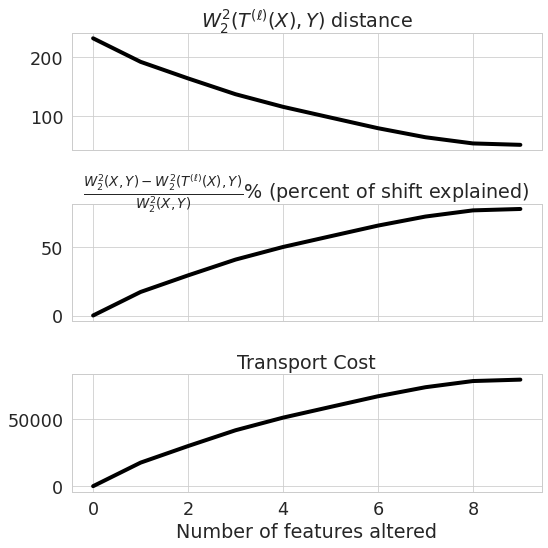

In [14]:
# Plotting results for sparse mean shift transport between E0, E1
plot_shift_results(W2s, W2_deltas, transport_costs)

#### Iterative unconstrained feature transport

In [15]:
def iterative_unconstrained_feature_transport(X, Y, T, log=False):
    if log:
        from time import time
        start_time = time()
        print('Calculating Zot')
    Z_OT = T.fit(X,Y).forward(X)
    if log:
        print('Zot calculated!')
    W2_X_Y = W2_dist(X, Y)  # calculating the W2 distance before any transporting
    X_means = X.mean(axis=0)
    Y_means = Y.mean(axis=0)
    argsorted_diff = np.linalg.norm(Z_OT - X, axis=0).argsort()[::-1]  # a feature-wise divergence array in decreasing order
    free_dim_mask = np.zeros(X.shape[1], dtype=bool)  # a mask where True mean that feature can be transported
    Z_constrained = X.copy()
    W2s = np.zeros(X.shape[1]+1)  # W_2^2 distances of each transport, including T=id
    W2s[0] = W2_X_Y
    W2_deltas = np.zeros(X.shape[1]+1)
    transport_costs = np.zeros(X.shape[1]+1)
    free_dims_over_time = [[]]
    for n_free in range(X.shape[1]):
        newest_free = argsorted_diff[n_free]  # selecting the next feature to be included in the transport
        free_dim_mask[newest_free] = True
        Z_constrained[:, newest_free] = Z_OT[:, newest_free]
        d_Z_Y = W2_dist(Y, Z_constrained)
        # recording
        percent_change = 100*(W2_X_Y - d_Z_Y) / W2_X_Y  # given as a %
        W2_deltas[n_free+1] = percent_change
        W2s[n_free+1] = d_Z_Y
        transport_costs[n_free+1] = calc_parsimony(X, Z_constrained)
        free_dims_over_time.append(np.flatnonzero(free_dim_mask))
        print(f'For {n_free+1} free,\tW2: {d_Z_Y:.3f},\tTotal shift explained: {percent_change:.1f}%')
    if log:
        print(f'\nTook {(time() - start_time)/60:.3} mins')
    return W2s, W2_deltas, transport_costs, free_dims_over_time

In [16]:
T = BaseTransport(X0, X1, fit=False, max_iter=1e9)
W2s, W2_deltas, transport_costs, free_dims_over_time = iterative_unconstrained_feature_transport(X0, X1, T, log=True)
E01_unconstrained_sparse_shift_results = [W2s, W2_deltas, transport_costs, free_dims_over_time]

Calculating Zot
Zot calculated!
For 1 free,	W2: 182.286,	Total shift explained: 21.0%
For 2 free,	W2: 148.857,	Total shift explained: 35.5%
For 3 free,	W2: 118.038,	Total shift explained: 48.8%
For 4 free,	W2: 87.846,	Total shift explained: 61.9%
For 5 free,	W2: 62.571,	Total shift explained: 72.9%
For 6 free,	W2: 43.371,	Total shift explained: 81.2%
For 7 free,	W2: 26.143,	Total shift explained: 88.7%
For 8 free,	W2: 11.919,	Total shift explained: 94.8%
For 9 free,	W2: 4.381,	Total shift explained: 98.1%

Took 0.00241 mins


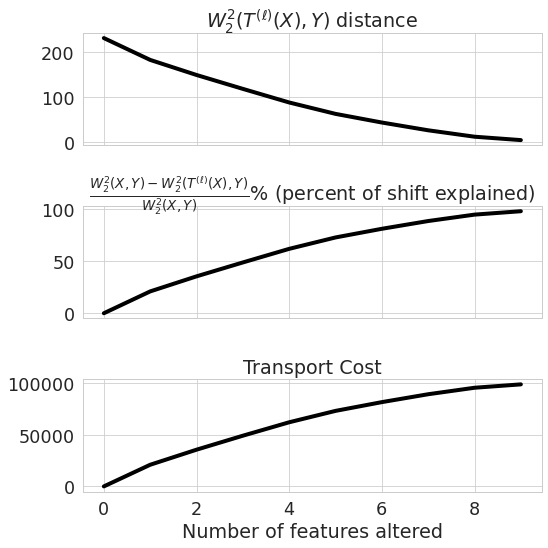

In [17]:
# Plotting results for unconstrained sparse shift transport between E0, E1
plot_shift_results(W2s, W2_deltas, transport_costs)

## Generating plots specifically to be shown in paper

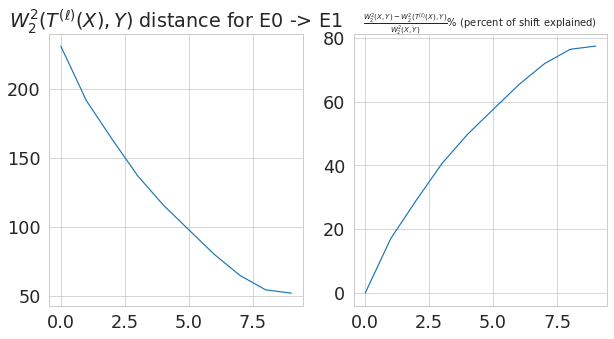

In [18]:
# Visualizing the Pareoto Frontier and % explained for E0->E1 for sparse mean shift
fontsize=10
figs, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(E01_sparse_mean_shift_results[0])
axes[0].set_title(r'$W_2^2 (T^{(\ell)}(X), Y)$ distance for E0 -> E1')
axes[1].plot(E01_sparse_mean_shift_results[1])
axes[1].set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)', fontsize=fontsize)
plt.show()

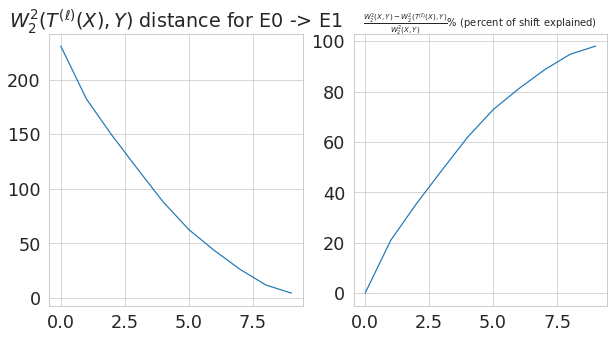

In [19]:
# Visualizing the % explained for both E0->E1 and E1->E2 for unconstrained sparse feature shift
fontsize=10
figs, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(E01_unconstrained_sparse_shift_results[0])
axes[0].set_title(r'$W_2^2 (T^{(\ell)}(X), Y)$ distance for E0 -> E1')
axes[1].plot(E01_unconstrained_sparse_shift_results[1])
axes[1].set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)', fontsize=fontsize)
plt.show()

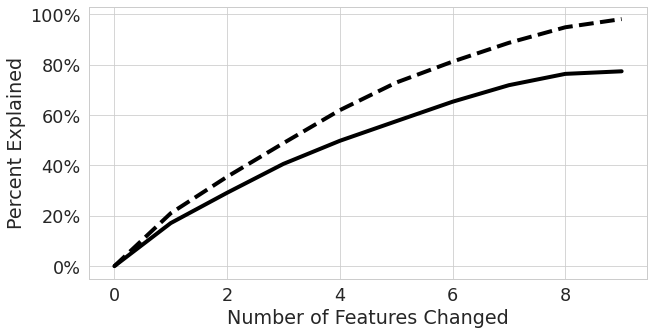

In [20]:
# Visualizing the Pareoto Frontier and % explained for both E0->E1 and E1->E2 for sparse mean shift
fontsize=15
figs, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(E01_sparse_mean_shift_results[1], **line_parms)
axes.plot(E01_unconstrained_sparse_shift_results[1], **line_parms, linestyle='--')
if add_title: axes.set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)', fontsize=fontsize)
for idx in range(1):
    axes.set_xlabel('Number of Features Changed')
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.tight_layout()
# plt.legend()
axes.set_ylabel('Percent Explained')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'mean-shift-E01-E12-percent-explained.{save_parms["format"]}', **save_parms)
plt.show()

In [21]:
# From the output of the mean shift transport experiment:
# Features: [5 1 2 7 3 0 6 4 8] have been shifted by: [6.28 5.27 5.15 4.6  4.24 4.22 3.89 3.22 1.54]

In [22]:
shifted_features_in_order = [5, 1, 2, 7, 3, 0, 6, 4, 8]
amount_features_shifted_by = [6.28, 5.27, 5.15, 4.6, 4.24, 4.22, 3.89, 3.22, 1.54]
for n_features_shifted in range(1,len(shifted_features_in_order)+1):
    shifted_feature_names = []
    for shifted_feature in shifted_features_in_order[:n_features_shifted]:
        shifted_feature_names.append(df.columns[shifted_feature])
    print(f'{shifted_feature_names} was shifted by\n {amount_features_shifted_by[:n_features_shifted]}\n')

['Bare Nuclei'] was shifted by
 [6.28]

['Bare Nuclei', 'Uniformity of Cell Size'] was shifted by
 [6.28, 5.27]

['Bare Nuclei', 'Uniformity of Cell Size', 'Uniformity of Cell Shape'] was shifted by
 [6.28, 5.27, 5.15]

['Bare Nuclei', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Normal Nucleoli'] was shifted by
 [6.28, 5.27, 5.15, 4.6]

['Bare Nuclei', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Normal Nucleoli', 'Marginal Adhesion'] was shifted by
 [6.28, 5.27, 5.15, 4.6, 4.24]

['Bare Nuclei', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Normal Nucleoli', 'Marginal Adhesion', 'Clump Thickness'] was shifted by
 [6.28, 5.27, 5.15, 4.6, 4.24, 4.22]

['Bare Nuclei', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Normal Nucleoli', 'Marginal Adhesion', 'Clump Thickness', 'Bland Chromatin'] was shifted by
 [6.28, 5.27, 5.15, 4.6, 4.24, 4.22, 3.89]

['Bare Nuclei', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Normal Nucleoli', 'Marginal 